In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib as mpl
mpl.use('Agg')
import seaborn as sns
from graph_tool.draw import sfdp_layout, graph_draw
from sklearn.metrics import average_precision_score

from helpers import infected_nodes
from graph_helpers import load_graph_by_name
from viz_helpers import lattice_node_pos

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [92]:
graph = 'grqc'
num_queries_to_show = 15
dataset_id = '{}-mic-s0.03-o0.1'.format(graph)
cascade_dir = 'cascade/{}'.format(dataset_id)
query_path = 'outputs/queries-weighted/{}/loop_erased/'.format(dataset_id)
inf_probas_path = 'outputs/inf_probas-weighted/{}/loop_erased/'.format(dataset_id)
fig_root_dir = 'figs/infection-probas-after-queries/{}'.format(dataset_id)

In [4]:
if not os.path.exists(fig_root_dir):
    os.makedirs(fig_root_dir)

In [5]:
cascade_id = 35

In [93]:
g = load_graph_by_name(graph)
if graph == 'lattice-1024':
    pos = lattice_node_pos(g, shape=(32, 32))
else:
    pos = sfdp_layout(g)

load graph from data/grqc/graph.gt


In [94]:
cascade_path = 'cascade-weighted/{}/{}.pkl'.format(dataset_id, cascade_id)
print('cascade path', cascade_path)
obs, c = pkl.load(open(cascade_path, 'rb'))
inf_nodes = infected_nodes(c)
print('{} the nodes ({:.2f} %) are infected'.format(len(inf_nodes), len(inf_nodes) / g.num_vertices() *100))

cascade path cascade-weighted/grqc-mic-s0.03-o0.1/35.pkl
234 the nodes (5.63 %) are infected


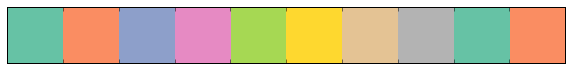

In [26]:
# color related

DEFAULT_COLOR_ID = 7
OBS_COLOR_ID = 4
QUERY_COLOR_ID = 1

DEFAULT_NODE_SIZE = 5
OBS_NODE_SIZE = 7.5
QUERY_NODE_SIZE = 10

pal = sns.color_palette("Set2", 10)
sns.palplot(pal)



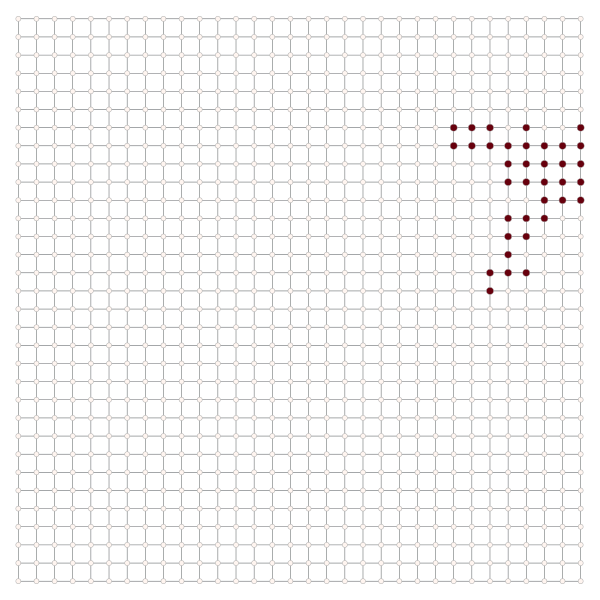

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fcc384e1208, at 0x7fcc38550f28>

In [27]:
node_color = g.new_vertex_property('int')
node_color.a = 0
for v in (c >= 0).nonzero()[0]:
    node_color[v] = 1

vertex_size = g.new_vertex_property('int')
vertex_size.a[c < 0] = DEFAULT_NODE_SIZE
vertex_size.a[c >= 0] = OBS_NODE_SIZE

vertex_order = g.new_vertex_property('int')
vertex_order.a = (c + 1)

graph_draw(g, pos=pos, vertex_fill_color=node_color, vertex_size=vertex_size,
           vorder=vertex_order,
           vcmap=mpl.cm.Reds,
           output=fig_root_dir+'/cascade.png')

In [38]:
def plot_inf_probas_after_queries(method):
    inf_probas_list = pkl.load(open(inf_probas_path + method + '/{}.pkl'.format(cascade_id), 'rb'))
    queries, _ = pkl.load(open(query_path + method + '/{}.pkl'.format(cascade_id), 'rb'))
    
    queries = queries[:num_queries_to_show]
    print(queries)
    probas_after_queries = inf_probas_list[num_queries_to_show-1]

    # some color smoothing
    probas_after_queries[probas_after_queries == 1] = 0.25
    
    vertex_fill_color = g.new_vertex_property('float')
    vertex_fill_color.a = probas_after_queries
    
    vertex_size = g.new_vertex_property('int')
    vertex_size.a = DEFAULT_NODE_SIZE
    vertex_size.a[queries] = QUERY_NODE_SIZE
    
    vertex_color = g.new_vertex_property('float')
    for v in g.vertices():
        vertex_color[v] = 0
    for q in queries:
        vertex_color[q] = 1
    
    node_order = g.new_vertex_property('float')
    node_order.a = probas_after_queries
    node_order.a[queries] = 1
    
    graph_draw(g, pos=pos,
               vertex_fill_color=vertex_fill_color,
               vertex_color=vertex_color,
               vertex_size=vertex_size,                
               vorder=node_order,
               vcmap=mpl.cm.Reds,
               output=fig_root_dir+'/probas_{}.png'.format(method))

[904, 903, 840, 935, 839, 838, 937, 870, 873, 837, 809, 874, 806, 774, 773]


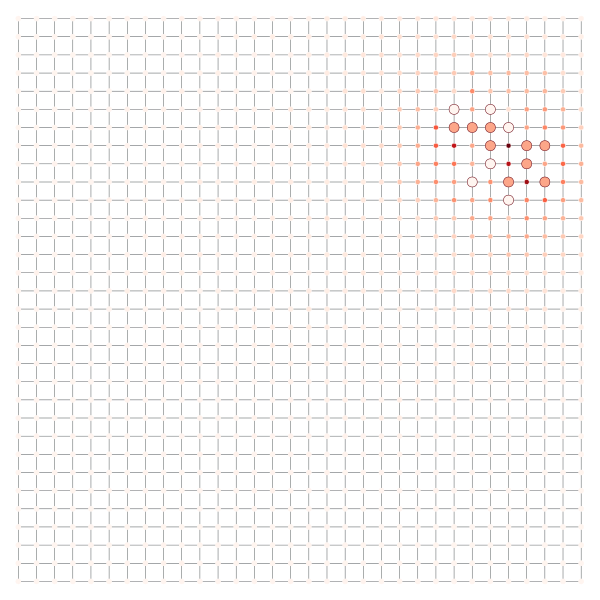

In [59]:
plot_inf_probas_after_queries('entropy')

[847, 997, 957, 79, 945, 937, 6, 677, 49, 980, 335, 237, 607, 738, 54]


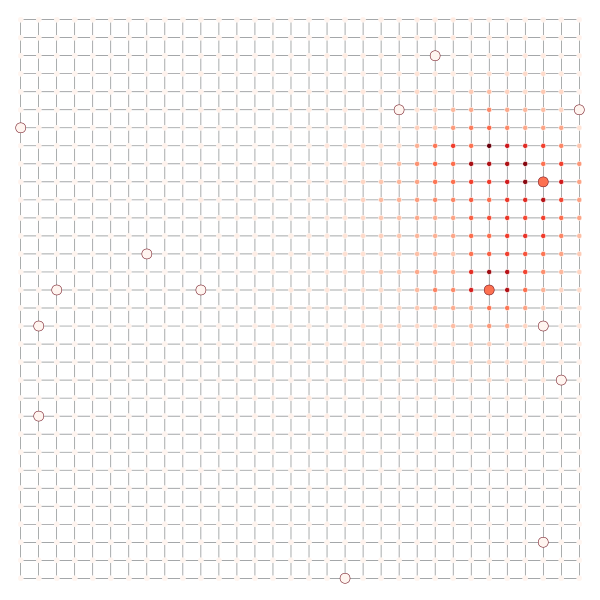

[498, 712, 642, 587, 833, 750, 772, 995, 875, 739, 743, 650, 708, 837, 615]


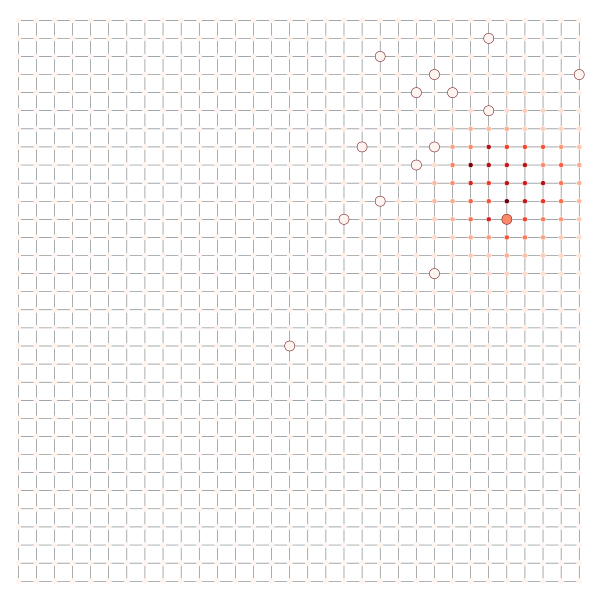

In [39]:
plot_inf_probas_after_queries('random')
plot_inf_probas_after_queries('prediction_error')

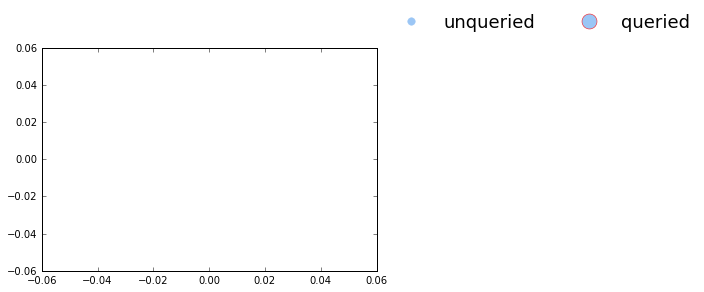

In [37]:
# plot_legend

import matplotlib.pyplot as plt

colors = ['#9BC6F5', '#9BC6F5']
edge_color = ['#9BC6F5', 'red']
sizes = [15, 30]
f = lambda m,c, size, ec: plt.plot([],[],marker=m, color=c, markersize=size, ls="none", markeredgecolor=ec)[0]
handles = [f(".", colors[i], sizes[i], edge_color[i]) for i in range(len(colors))]
labels = ['unqueried', 'queried']
legend = plt.legend(handles, labels, loc=3, 
                    ncol=len(colors), numpoints=1,
                    bbox_to_anchor=(1,1),
                    fontsize=18,
                    framealpha=1, frameon=False)


def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend, 'figs/infection-probas-after-queries/legend.png')
plt.show()

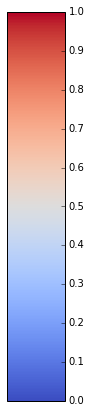

In [38]:
import pylab as pl
import numpy as np

orientation = 'vertical'

a = np.array([[0,1]])
if orientation == 'vertical':
    pl.figure(figsize=(1, 9))
else:
    pl.figure(figsize=(9, 1))
img = pl.imshow(a, cmap="coolwarm")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation=orientation, cax=cax)
pl.savefig("figs/infection-probas-after-queries/colorbar_{}.pdf".format(orientation))



In [54]:
inf_probas[mask]

IndexError: arrays used as indices must be of integer (or boolean) type

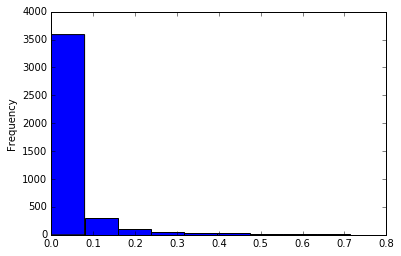

In [95]:
method = 'random'
inf_probas_list = pkl.load(open(inf_probas_path + method + '/{}.pkl'.format(cascade_id), 'rb'))
queries, _ = pkl.load(open(query_path + method + '/{}.pkl'.format(cascade_id), 'rb'))

obs_and_queries = list(obs) + queries[:10]
inf_probas = inf_probas_list[9]
mask = np.ones(len(inf_probas), dtype=np.bool)
mask[obs_and_queries] = 0
pd.Series(inf_probas[mask]).plot('hist')